### Original source  
https://github.com/LeonardoBerti00/TABL-Temporal-Attention-Augmented-Bilinear-Network-for-Financial-Time-Series-Data-Analysis

### **TABL**

In [1]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### **Data**
The dataset in the folder Dataset is the FI-2010 dataset zipped and normalized. 

As in the original paper I used the firs 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [2]:
# please change the data_path to your local path and download the files you need from the web site of the dataset

#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
#dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_data = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Training/Train_Dst_Auction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_9.txt')
#dec_test1 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_7.txt')
#dec_test2 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_8.txt')
#dec_test3 = np.loadtxt('data/FI-2010/BenchmarkDatasets/Auction/3.Auction_DecPre/Auction_DecPre_Testing/Test_Dst_Auction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

# dec_train.shape = (149, 203800)

h = 2        #if h = 2, than horizon = 50
T = 50      #horizon 
dim = 20
k = T//10    #horizon

t_offset = 0   # original label
t_offset = k-1 # fixed label. temporal shifted

y_train = dec_train[-h, :].flatten()
# y_train.shape = (203800,)
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

# 10-1: 10 means the length of inputs
# second -1 means [1,2,3] to [0,1,2] conversion of class id
y_train = y_train[dim-1+t_offset:] - 1
#y_train = y_train[dim-1:] - 1
# y_train.shape = (203791,) # 203791 = 203800-(10+1)
y_val = y_val[dim-1+t_offset:] - 1
#y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1+t_offset:] - 1 
#y_test = y_test[dim-1:] - 1 

# First 40 features = 10*4 features
dec_train = np.concatenate([dec_train[:40, :].T, dec_train[50:51, :].T], axis=1)
# dec_train.shape = (203800, 40)
#dec_val = dec_val[:40, :].T
dec_val = np.concatenate([dec_val[:40, :].T, dec_val[50:51, :].T], axis=1)
#dec_test = dec_test[:40, :].T
dec_test = np.concatenate([dec_test[:40, :].T, dec_test[50:51, :].T], axis=1)

In [3]:
#computing the weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        #self.length = x.shape[0] - (T/10) - self.dim + 1
        self.length = x.shape[0] - ((T//10)-1) - self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [5]:
#Hyperparameters
batch_size = 256
epochs = 200
   
lr = 0.01
num_classes = 3
#dim = 10

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

60568
155151
242337


In [6]:
dec_train[0, 0]

0.35983073

In [7]:
for i,(x,y) in enumerate(dataset_train):
    print(x.shape, y.shape)
    n = x.shape[0]
    mids = (x[0, :] + x[2, :])/2
    print(mids)
    break

torch.Size([41, 20]) torch.Size([])
tensor([0.3543, 0.3688, 0.3688, 0.3688, 0.3688, 0.3708, 0.3673, 0.3673, 0.3688,
        0.3673, 0.3683, 0.3643, 0.3598, 0.3598, 0.3598, 0.3598, 0.3598, 0.3598,
        0.3598, 0.3598], dtype=torch.float64)


### **Model Architecture**


In [8]:
import torch.nn as nn

class TSBatchNorm2d(nn.Module):

    def __init__(self):
        super(TSBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)

        # Reshape input_data to (batch_size, 1, timepoints, features)
        x = x.unsqueeze(1)

        # Forward pass
        output = self.bn(x)

        # Reshape the output back to (batch_size, timepoints, features)
        output = output.squeeze(1)
        return output

class TSTimeMixingResBlock(nn.Module):

    def __init__(self, width_time: int, dropout: float):
        super(TSTimeMixingResBlock, self).__init__()
        self.norm = TSBatchNorm2d()

        self.lin = nn.Linear(in_features=width_time, out_features=width_time)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.norm(x)
        
        # Now rotate such that shape is (batch_size, features, time)
        y = torch.transpose(y, 1, 2)
        
        # Apply MLP to time dimension
        y = self.lin(y)
        y = self.act(y)

        # Rotate back such that shape is (batch_size, time, features)
        y = torch.transpose(y, 1, 2)

        # Dropout
        y = self.dropout(y)
                
        # Add residual connection
        return x + y


class TSFeatMixingResBlock(nn.Module):

    def __init__(self, width_feats: int, width_feats_hidden: int, dropout: float):
        super(TSFeatMixingResBlock, self).__init__()
        self.norm = TSBatchNorm2d()

        self.lin_1 = nn.Linear(in_features=width_feats, out_features=width_feats_hidden)
        self.lin_2 = nn.Linear(in_features=width_feats_hidden, out_features=width_feats)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.act = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.norm(x)
        
        # Apply MLP to feat dimension
        y = self.lin_1(y)
        y = self.act(y)
        y = self.dropout_1(y)
        y = self.lin_2(y)
        y = self.dropout_2(y)
                
        # Add residual connection
        return x + y


class TSMixingLayer(nn.Module):

    def __init__(self, input_length: int, no_feats: int, feat_mixing_hidden_channels: int, dropout: float):
        super(TSMixingLayer, self).__init__()
        self.time_mixing = TSTimeMixingResBlock(width_time=input_length, dropout=dropout)
        self.feat_mixing = TSFeatMixingResBlock(width_feats=no_feats, width_feats_hidden=feat_mixing_hidden_channels, dropout=dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        y = self.time_mixing(x)
        y = self.feat_mixing(y)
        return y


class TSTemporalProjection(nn.Module):

    def __init__(self, input_length: int, forecast_length: int):
        super(TSTemporalProjection, self).__init__()
        self.lin = nn.Linear(in_features=input_length, out_features=forecast_length)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        # Now rotate such that shape is (batch_size, features, time=input_length)
        y = torch.transpose(x, 1, 2)

        # Apply linear projection -> shape is (batch_size, features, time=forecast_length)
        y = self.lin(y)

        # Rotate back such that shape is (batch_size, time=forecast_length, features)
        y = torch.transpose(y, 1, 2)
        return y


class TSMixerModelExclRIN(nn.Module):

    def __init__(self, input_length: int, forecast_length: int, no_feats: int, feat_mixing_hidden_channels: int, no_mixer_layers: int, dropout: float):
        super(TSMixerModelExclRIN, self).__init__()
        self.temp_proj = TSTemporalProjection(input_length=input_length, forecast_length=forecast_length)
        mixer_layers = []
        for _ in range(no_mixer_layers):
            mixer_layers.append(TSMixingLayer(input_length=input_length, no_feats=no_feats, feat_mixing_hidden_channels=feat_mixing_hidden_channels, dropout=dropout))
        self.mixer_layers = nn.ModuleList(mixer_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)
        for mixer_layer in self.mixer_layers:
            x = mixer_layer(x)

        # Apply temporal projection -> shape is (batch_size, time=forecast_length, features)
        x = self.temp_proj(x)

        return x


class TSMixerModel(nn.Module):
    """Include Reversible instance normalization https://openreview.net/pdf?id=cGDAkQo1C0p
    """    

    def __init__(self, 
                 input_length: int, 
                 forecast_length: int, 
                 no_feats: int, 
                 feat_mixing_hidden_channels: int, 
                 no_mixer_layers: int,  
                 dropout: float, 
                 eps: float = 1e-8):
        super(TSMixerModel, self).__init__()
        self.eps = eps

        # Scale and shift params to learn
        self.scale = nn.Parameter(torch.ones(no_feats))
        self.shift = nn.Parameter(torch.zeros(no_feats))

        # ts mixer layers
        self.ts = TSMixerModelExclRIN(
            input_length=input_length, 
            forecast_length=forecast_length, 
            no_feats=no_feats, 
            feat_mixing_hidden_channels=feat_mixing_hidden_channels,
            no_mixer_layers=no_mixer_layers,
            dropout=dropout
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input x: (batch_size, time, features)

        # Compute mean, var across time dimension
        # mean: (batch_size, 1, features)
        # var: (batch_size, 1, features)
        mean = torch.mean(x, dim=1, keepdim=True)
        var = torch.var(x, dim=1, keepdim=True)

        # Normalize across time dimension
        # x: (batch_size, time, features)
        x = (x - mean) / torch.sqrt(var + self.eps)

        # Apply scale and shift in each feature dimension separately
        # x: (batch_size, time, features)
        # scale: (features)
        # shift: (features)
        x = x * self.scale + self.shift

        # Apply ts mixer layers
        x = self.ts(x)

        # Apply inverse scale and shift in each feature dimension separately
        # x: (batch_size, time, features)
        # scale: (features)
        # shift: (features)
        x = (x - self.shift) / self.scale

        # Unnormalize across time dimension
        # x: (batch_size, time, features)
        # mean: (batch_size, 1, features)
        # var: (batch_size, 1, features)
        x = x * torch.sqrt(var + self.eps) + mean

        return x

In [9]:
class TSMixer_lob(torch.nn.Module):
    def __init__(self,
                 label_index=None, input_length=24, forecast_length=5,
                 no_feats=19,
                 feat_mixing_hidden_channels=64,
                 no_mixer_layers=8,
                 dropout=0.7):
        super().__init__()

        self.tsmixermodel = TSMixerModel(input_length=input_length,
                                          forecast_length=forecast_length,
                                          no_feats=no_feats, 
                                          feat_mixing_hidden_channels=feat_mixing_hidden_channels,
                                          no_mixer_layers=no_mixer_layers,
                                          dropout=dropout)

        channels = no_feats
        self.label_index = label_index
        self.mse = torch.nn.MSELoss(reduction='none')
        if label_index is None:
            self.out_channels = channels
        else:
            self.out_channels = len(label_index)
        #self.linear1 = torch.nn.Linear(channels, 512)
        #self.linear2 = torch.nn.Linear(512, OUT_STEPS*self.out_channels)
        #self.relu = torch.nn.ReLU()

    def forward(
        self,
        inputs: torch.Tensor
    ):
        inputs = torch.permute(inputs, (0, 2, 1))
        x = inputs
        #print('### debug 1')
        #print(inputs.shape)

        x = self.tsmixermodel(inputs)
        # last 1 as feature
        # is it right????
        x = x[:, :, -1:]
        m_i = (inputs[:, -1, 0] + inputs[:, -1, 2])/2.
        l_i = (torch.mean(x[:,:,0], dim=1)-m_i)/m_i
        print('x =', x[0, :, :])
        print('m_i =', m_i[0])
        print('mean =', torch.mean(x[0:1,:,0], dim=1))
        print('l_i =', l_i[0])

        y = torch.zeros((inputs.shape[0], 3), device=device)

        thres = 0.00002
        y[:, 0] = (l_i >= thres)
        y[:, 2] = (l_i <= -thres)
        y[:, 1] = 1.0 - (y[:, 0] + y[:, 2])

        return y


### **Model Training**

I implemented the second setting of the experiment

In [10]:
#Choose between B(TABL) and C(TABL)

#model = BTABL(120, 40, 10, 5, 3, 1)
#model = CTABL(60, 40, 10, 10, 120, 5, 3, 1)
model = TSMixer_lob(label_index=['mid'],
                    input_length=dim,
                    forecast_length=5,
                    no_feats=41)

model.to(device)

'''
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    SC = [0.005, 0.001, 0.0005, 0.0001]
    i = 0
    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print('### debug 22')
            #print(outputs.shape)
            #print(targets.shape)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        if (train_losses[it-1] <= train_loss and i < 4 and it != 0):
              for g in optimizer.param_groups:
                g['lr'] = SC[i]
              i += 1
              

        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            #outputs = torch.squeeze(outputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, './best_model_CTABL')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses
'''
None

In [11]:
'''
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
'''
None

### **Model Testing**

In [12]:
#model = torch.load('./best_model_CTABL')
#model = torch.load('./best_model_tsmixer_10_5')
model.load_state_dict(torch.load('./best_model_tsmixer_%d_5'%dim))

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for i, (inputs, targets) in enumerate(test_loader):
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    #print(outputs)
    #print(predictions)
    #print(targets)
    #print((predictions == targets).sum().item(), targets.shape[0])

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

x = tensor([[0.3740],
        [0.3807],
        [0.3736],
        [0.3751],
        [0.3727]], device='cuda:0', grad_fn=<SliceBackward0>)
m_i = tensor(0.3783, device='cuda:0')
mean = tensor([0.3752], device='cuda:0', grad_fn=<MeanBackward1>)
l_i = tensor(-0.0080, device='cuda:0', grad_fn=<SelectBackward0>)
x = tensor([[0.3981],
        [0.3985],
        [0.3965],
        [0.3981],
        [0.3982]], device='cuda:0', grad_fn=<SliceBackward0>)
m_i = tensor(0.3972, device='cuda:0')
mean = tensor([0.3979], device='cuda:0', grad_fn=<MeanBackward1>)
l_i = tensor(0.0016, device='cuda:0', grad_fn=<SelectBackward0>)
x = tensor([[0.4035],
        [0.4030],
        [0.4027],
        [0.4041],
        [0.4038]], device='cuda:0', grad_fn=<SliceBackward0>)
m_i = tensor(0.4037, device='cuda:0')
mean = tensor([0.4034], device='cuda:0', grad_fn=<MeanBackward1>)
l_i = tensor(-0.0007, device='cuda:0', grad_fn=<SelectBackward0>)
x = tensor([[0.4102],
        [0.4100],
        [0.4104],
        [0.4095],
 

accuracy_score: 0.3165432385224717
              precision    recall  f1-score   support

           0     0.2682    0.5029    0.3498     42507
           1     0.6834    0.1405    0.2331     73156
           2     0.2890    0.4421    0.3495     39488

    accuracy                         0.3165    155151
   macro avg     0.4135    0.3618    0.3108    155151
weighted avg     0.4693    0.3165    0.2947    155151



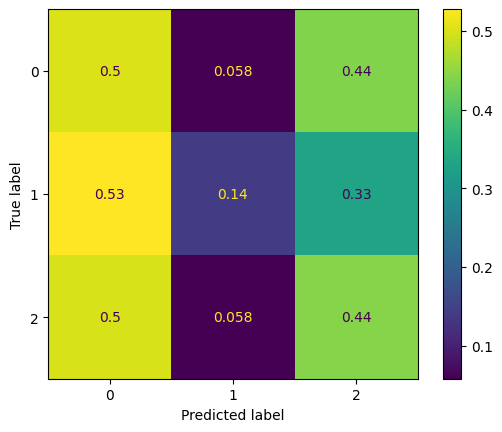

In [13]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()